In [11]:
!pip install albumentations as A
!pip install albumentations.pytorch import ToTensorV2
!pip install numpy as np
!pip install nibabel
!pip install torch
!pip install tensorflow
!pip install nibabel as nib

%pip install nibabel
%pip install opencv-python
%pip install albumentations
%pip install segmentation_models_pytorch


import nibabel as nib
from torch.utils.data import Dataset
import tensorflow as tf
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

print(f"Step 1: Installation and imports done")


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement albumentations.pytorch (from versions: none)
ERROR: No matching distribution found for albumentations.pytorch
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
Step 1: Installation and imports done


In [16]:
print(f"Step 2: Setting path and method defenitions ")
DATA_DIR = "/content/drive/My Drive/data/ISLES-2022"  # or your actual data folder path
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_train_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=0, std=1, max_pixel_value=1.0),
        ToTensorV2()
    ])

class ISLESDataset3D(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        print(f"entering to extract 3D samples")
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")
                    dwi_path = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    flair_path = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]
                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]
                    if dwi_path and flair_path and mask_path:
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_path[0]),
                            "flair": os.path.join(anat_dir, flair_path[0]),
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total 3D samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi = self.load_nifti(sample["dwi"])    # [H, W, D]
        flair = self.load_nifti(sample["flair"])  # [H, W, D]

        # Crop both to the minimum shape
        min_shape = np.minimum(dwi.shape, flair.shape)
        dwi_cropped = dwi[:min_shape[0], :min_shape[1], :min_shape[2]]
        flair_cropped = flair[:min_shape[0], :min_shape[1], :min_shape[2]]

        x = np.stack([dwi_cropped, flair_cropped], axis=0)  # [2, H, W, D]
        y = self.load_nifti(sample["mask"])
        y = y[:min_shape[0], :min_shape[1], :min_shape[2]]  # Crop mask to match

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    @staticmethod
    def load_nifti(path):
        return np.asarray(nib.load(path).get_fdata(), dtype=np.float32)


class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        # Down part
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature
        self.bottleneck = DoubleConv3D(features[-1], features[-1]*2)
        in_channels = features[-1]*2  # after bottleneck

        # Up part (only ONCE!)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(in_channels, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv3D(feature * 2, feature))
            in_channels = feature  # update for next up block

        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool3d(x, 2)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]
            # Pad if needed
            diffD = skip.shape[2] - x.shape[2]
            diffH = skip.shape[3] - x.shape[3]
            diffW = skip.shape[4] - x.shape[4]
            x = F.pad(
                x,
                [diffW // 2, diffW - diffW // 2,
                 diffH // 2, diffH - diffH // 2,
                 diffD // 2, diffD - diffD // 2]
            )
            # Crop if needed (for negative diffs)
            if x.shape[2] > skip.shape[2]:
                x = x[:, :, :skip.shape[2], :, :]
            if x.shape[3] > skip.shape[3]:
                x = x[:, :, :, :skip.shape[3], :]
            if x.shape[4] > skip.shape[4]:
                x = x[:, :, :, :, :skip.shape[4]]
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)
        return torch.sigmoid(self.final_conv(x))

    @staticmethod
    def get_unet(in_channels=2, out_channels=1):
      return UNet3D(in_channels=in_channels, out_channels=out_channels)


def load_ensemble(model_paths, device):
    models = []
    for path in model_paths:
        model = UNet3D.get_unet()
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        model.to(device)
        models.append(model)
    return models

def ensemble_predict(models, x):
    with torch.no_grad():
        preds = [model(x) for model in models]
    stacked = torch.stack(preds, dim=0)
    avg = torch.mean(stacked, dim=0)
    final = (avg > 0.5).float()
    return final, avg


def predict_and_show_ensemble(data_folder, model_paths, idx=0, slice_idx=None):
    dataset = ISLESDataset3D(data_folder)
    if len(dataset) == 0:
        print("No samples found.")
        return

    models = load_models(model_paths)
    ensemble_model = EnsembleSegmentationModel(models)

    x, y = dataset[idx]
    x = x.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred = ensemble_model(x)

    pred_np = pred.squeeze().numpy()
    flair_np = x[0, 1].numpy()
    mask_np = y.numpy()

    # Choose a slice index (center if not specified)
    if slice_idx is None:
        slice_idx = flair_np.shape[2] // 2

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("FLAIR (center slice)")
    plt.imshow(flair_np[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_np[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Ensemble Predicted Mask")
    plt.imshow(pred_np[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.show()

def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    bce = nn.BCELoss()
    for x, y in loader:
        x, y = x.to(DEVICE, dtype=torch.float), y.to(DEVICE, dtype=torch.float)
        x = x[..., x.shape[-1] // 2]
        y = y[..., y.shape[-1] // 2]
        if x.shape[1] > 2:
             x = x[:, :2, ...]
        y = y.unsqueeze(1)
        optimizer.zero_grad()
        out = model(x)
        loss = 0.5 * bce(out, y) + 0.5 * dice_loss(out, y)
        loss.backward()
        optimizer.step()

def train_ensemble(data_dir, n_models=3, epochs=2, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loader = get_dataloaders(data_dir, batch_size)
    for i in range(n_models):
        model = UNet3D.get_unet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        for epoch in range(epochs):
            train_one_epoch(model, loader, optimizer, device)
        torch.save(model.state_dict(), drive_path+f"base_model_{i}.pth")


def dice_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_sample(x, y, pred, channel=0):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input (selected channel)")
    plt.imshow(x[channel].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y.squeeze().cpu(), cmap='gray')  # <--- fix here
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().cpu(), cmap='gray')  # <--- fix here
    plt.axis('off')
    plt.show()

def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

print(f"Prepare dataset and dataloader",DEVICE)
drive.mount('/content/drive')
def pad_collate(batch):
    xs, ys = zip(*batch)
    # Find max height, width, depth in this batch
    max_h = max(x.shape[-3] for x in xs)
    max_w = max(x.shape[-2] for x in xs)
    max_d = max(x.shape[-1] for x in xs)
    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        pad_h = max_h - x.shape[-3]
        pad_w = max_w - x.shape[-2]
        pad_d = max_d - x.shape[-1]
        # Pad as (left, right, top, bottom, front, back)
        # F.pad uses (D1, D2, H1, H2, W1, W2) for 5D tensors
        # For 4D tensors: (N, C, H, W, D) or (C, H, W, D)
        # Here, x is likely (C, H, W, D)
        x_padded = F.pad(x, (0, pad_d, 0, pad_w, 0, pad_h))
        y_padded = F.pad(y, (0, pad_d, 0, pad_w, 0, pad_h))
        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
    xs_padded = torch.stack(xs_padded)
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded

def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x
def lesion_wise_f1_score(predicted_mask, ground_truth_mask, smooth=1e-6):
    """
    Calculates the lesion-wise F1 score.

    Args:
        predicted_mask (torch.Tensor or np.ndarray): The predicted mask.
                                                     Should be a binary mask (0 or 1).
        ground_truth_mask (torch.Tensor or np.ndarray): The ground truth mask.
                                                        Should be a binary mask (0 or 1).
        smooth (float): A small value to avoid division by zero.

    Returns:
        float: The lesion-wise F1 score. Returns 1.0 if both masks are entirely background.
    """
    # Ensure inputs are torch tensors and on the same device
    if isinstance(predicted_mask, np.ndarray):
        predicted_mask = torch.from_numpy(predicted_mask).float()
    if isinstance(ground_truth_mask, np.ndarray):
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()

    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0.5).float()
    ground_truth_mask = (ground_truth_mask > 0.5).float()

    # Flatten the masks
    predicted_mask = predicted_mask.view(-1)
    ground_truth_mask = ground_truth_mask.view(-1)

    # Calculate True Positives, False Positives, and False Negatives
    true_positives = torch.sum(predicted_mask * ground_truth_mask)
    false_positives = torch.sum(predicted_mask * (1 - ground_truth_mask))
    false_negatives = torch.sum((1 - predicted_mask) * ground_truth_mask)

    # Calculate Precision and Recall
     # Calculate Precision and Recall
    precision = (true_positives + smooth) / (true_positives + false_positives + smooth)
    recall = (true_positives + smooth) / (true_positives + false_negatives + smooth)

    # Calculate F1 score
    f1 = (2. * precision * recall + smooth) / (precision + recall + smooth)

    # Handle the case where both masks are entirely background
    if torch.sum(ground_truth_mask) == 0 and torch.sum(predicted_mask) == 0:
        return 1.0  # Perfect score if no lesion and none predicted

    return f1.item()  # Return as a Python number

def absolute_volume_difference(predicted_mask, ground_truth_mask):
    """
    Calculates the Absolute Volume Difference (AVD) between two masks.

    Args:
        predicted_mask (torch.Tensor or np.ndarray): The predicted mask.
                                                     Should be a binary mask (0 or 1).
        ground_truth_mask (torch.Tensor or np.ndarray): The ground truth mask.
                                                        Should be a binary mask (0 or 1).

    Returns:
        float: The Absolute Volume Difference as a percentage.
               Calculated as |Vp - Vt| / Vt * 100, where Vp is the volume
               of the predicted mask and Vt is the volume of the ground truth mask.
               Returns 0 if the ground truth mask volume is 0.
    """
    # Ensure inputs are torch tensors and on the same device
    if isinstance(predicted_mask, np.ndarray):
        predicted_mask = torch.from_numpy(predicted_mask).float()
    if isinstance(ground_truth_mask, np.ndarray):
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()

    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0.5).float()
    ground_truth_mask = (ground_truth_mask > 0.5).float()

    # Calculate volumes (sum of pixels/voxels)
    volume_predicted = torch.sum(predicted_mask)
    volume_ground_truth = torch.sum(ground_truth_mask)

    # Calculate AVD
    if volume_ground_truth == 0:
        # Avoid division by zero if the ground truth has no lesion
        if volume_predicted == 0:
            return 0.0
        else:
            # If ground truth is 0 and prediction is not, AVD is infinite,
            # but for practical purposes, we might want to return a large value
            # or handle this case specifically. Returning 100% as a simple case.
             return 100.0
    else:
        avd = torch.abs(volume_predicted - volume_ground_truth) / volume_ground_truth * 100.0
        return avd.item() # Return as a Python number

import matplotlib.pyplot as plt

def plot_sample_colored(x, y, pred, channel=0):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    img = x[channel]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    ax.imshow(img, cmap='gray')
    ax.imshow(y, cmap='Greens', alpha=0.3)      # Ground truth in green
    ax.imshow(pred, cmap='Reds', alpha=0.3)     # Prediction in red
    ax.set_title("Input + GT (green) + Pred (red)")
    ax.axis('off')
    plt.show()

print(f"#Load ensemble models")
model_paths = [drive_path+f"/base_model_{i}.pth" for i in range(N_MODELS)]
ensemble_models = load_ensemble(model_paths, DEVICE)

print(f"#Ensemble prediction on a batch")
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))
x = x.to(DEVICE, dtype=torch.float)
y = y.to(DEVICE, dtype=torch.float)
if x.shape[1] > 2:
    x = x[:, :2, ...]  # Ensure only 2 channels
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)  # Use full 3D volume

# For visualization, take a middle slice
mid_slice = x.shape[2] // 2  # D axis
x_vis = x[:, :, mid_slice, :, :]  # [B, 2, H, W]
y_vis = y[:, :, mid_slice, :, :] if y.ndim == 5 else y[:, mid_slice, :, :]
final_mask_vis = final_mask[:, 0, mid_slice, :, :]  # [B, H, W]
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)


Step 2: Setting path and method defenitions 
Prepare dataset and dataloader cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
#Load ensemble models
#Ensemble prediction on a batch
Input min/max: tensor(-12.7427) tensor(1344.6132)
Mask unique values: tensor([0., 1.])


In [13]:

drive_path = '/content/drive/My Drive'  # Replace 'MyDrive' with the specific folder if needed

# List all files and directories in the drive
for item in os.listdir(drive_path):
    item_path = os.path.join(drive_path, item)
    if os.path.isdir(item_path):
       print(item)

train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
print("Sample mask unique:", torch.unique(sample_y))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

data
src
entering to extract 3D samples
Total 3D samples: 250
Sample mask unique: tensor([0., 1.])
Number of samples in dataset: 250
Number of batches in DataLoader: 84


In [14]:
N_MODELS = 3
EPOCHS = 4
BATCH_SIZE = 3

print(f"#Train multiple base models for ensemble")
for i in range(N_MODELS):
    model = UNet3D.get_unet(in_channels=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        model.train()
        print(f"Training model {i}, epoch {epoch+1}/{EPOCHS}")
       # ...existing code...
    # In your training loop:
    for batch_idx, (x, y) in enumerate(train_loader):
        target_shape = (128, 128, 64)
        # Ensure correct dims and type
        if x.ndim == 4:
            x = x.unsqueeze(0)
        if x.ndim == 5 and x.shape[1] > 2:
            x = x[:, :2, ...]
        x = safe_pad_or_crop(x, target_shape)
        x = x.to(DEVICE, dtype=torch.float)
        # Mask handling
        y = safe_unsqueeze_mask(y)
        y = safe_pad_or_crop(y, target_shape)
        y = y.to(DEVICE, dtype=torch.float)
        y = y.clamp(0, 1)  # Ensure mask is binary/float

        # For y (mask), shape: [B, D, H, W]
        optimizer.zero_grad()
        out = model(x)
        bce = torch.nn.BCELoss()
        loss = 0.5 * bce(out, y) + 0.5 * (1 - dice_score(out, y))
        loss.backward()
        optimizer.step()
        print(f"  Model {i} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}")
    print(f"\nEvaluating individual model {i}...")
    model.eval() # Set model to evaluation mode
    individual_dice_scores = []
    individual_avd_scores = []
    individual_f1_scores = []

    with torch.no_grad(): # No need to calculate gradients during evaluation
        for batch_idx, (x, y) in enumerate(train_loader): # Using train_loader for simplicity, ideally use a validation loader
            target_shape = (128, 128, 64)
            # Preprocessing (same as training)
            if x.ndim == 4:
                x = x.unsqueeze(0)
            if x.ndim == 5 and x.shape[1] > 2:
                x = x[:, :2, ...]
            x = safe_pad_or_crop(x, target_shape)
            x = x.to(DEVICE, dtype=torch.float)
            y = safe_unsqueeze_mask(y)
            y = safe_pad_or_crop(y, target_shape)
            y = y.to(DEVICE, dtype=torch.float)
            y = y.clamp(0, 1)

            # Prediction
            individual_pred = model(x)

            # Calculate metrics for the batch
            for sample_in_batch in range(x.shape[0]):
                # Assuming y and individual_pred are [B, 1, D, H, W]
                gt_mask = y[sample_in_batch, 0]
                pred_mask = individual_pred[sample_in_batch, 0]

                individual_dice_scores.append(dice_score(pred_mask, gt_mask).item())
                individual_avd_scores.append(absolute_volume_difference(pred_mask, gt_mask))
                individual_f1_scores.append(lesion_wise_f1_score(pred_mask, gt_mask))

    avg_individual_dice = np.mean(individual_dice_scores) if individual_dice_scores else 0
    avg_individual_avd = np.mean(individual_avd_scores) if individual_avd_scores else 0
    avg_individual_f1 = np.mean(individual_f1_scores) if individual_f1_scores else 0

    print(f"  Model {i} Performance:")
    print(f"    Average Dice Score: {avg_individual_dice:.4f}")
    print(f"    Average AVD: {avg_individual_avd:.2f}%")
    print(f"    Average Lesion-wise F1: {avg_individual_f1:.4f}")
    # --- End Evaluation for Individual Model ---


    torch.save(model.state_dict(), f"base_UNET3D_model_{i}.pth")
    print(f"Saved base_model_{i}.pth")



#Train multiple base models for ensemble
Training model 0, epoch 1/4
Training model 0, epoch 2/4
Training model 0, epoch 3/4
Training model 0, epoch 4/4
  Model 0 Epoch 4 Batch 0/84 Loss: 0.8504
Saved base_model_0.pth
Training model 1, epoch 1/4
Training model 1, epoch 2/4
Training model 1, epoch 3/4
Training model 1, epoch 4/4
  Model 1 Epoch 4 Batch 0/84 Loss: 0.8236
Saved base_model_1.pth
Training model 2, epoch 1/4
Training model 2, epoch 2/4
Training model 2, epoch 3/4
Training model 2, epoch 4/4
  Model 2 Epoch 4 Batch 0/84 Loss: 0.8032
Saved base_model_2.pth


#Load ensemble models
#Ensemble prediction on a batch
Input min/max: tensor(-15.2707) tensor(1631.4949)
Mask unique values: tensor([0., 1.])
#Evaluate and visualize
Sample 0: slice 62, input min/max: 0.0 622.7255859375
Sample 0: mask unique: tensor([0., 1.], device='cuda:0')
Sample 0: pred unique: tensor([0.], device='cuda:0')
Sample 0: AVD = 100.00%, Lesion-wise F1 = 0.000


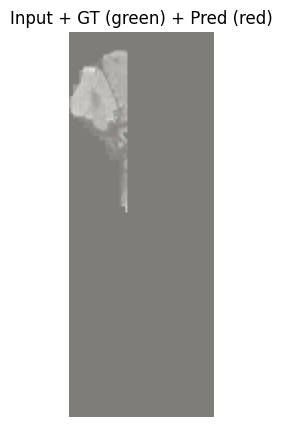

Sample 1: slice 73, input min/max: 0.0 528.9990234375
Sample 1: mask unique: tensor([0., 1.], device='cuda:0')
Sample 1: pred unique: tensor([0., 1.], device='cuda:0')
Sample 1: AVD = 770.21%, Lesion-wise F1 = 0.053


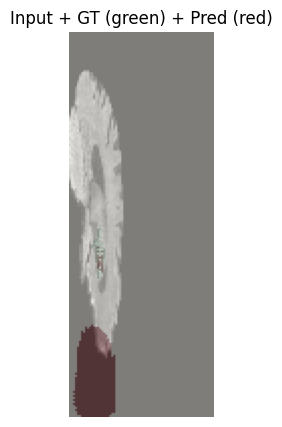

Sample 2: slice 69, input min/max: -9.21726131439209 808.8931884765625
Sample 2: mask unique: tensor([0., 1.], device='cuda:0')
Sample 2: pred unique: tensor([0.], device='cuda:0')
Sample 2: AVD = 100.00%, Lesion-wise F1 = 0.000


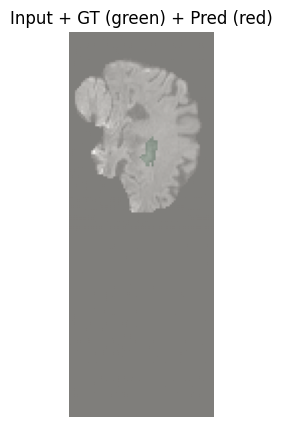

In [15]:

print(f"#Evaluate and visualize")
for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find a slice with nonzero mask, else use middle
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    nonzero_slices = torch.where(mask_3d.sum(dim=(-1, -2)) > 0)[0]
    if len(nonzero_slices) > 0:
        slice_idx = int(nonzero_slices[len(nonzero_slices)//2])
    else:
        slice_idx = x.shape[2] // 2  # fallback to middle

    print(f"Sample {i}: slice {slice_idx}, input min/max:", x[i, 0, slice_idx].min().item(), x[i, 0, slice_idx].max().item())
    print(f"Sample {i}: mask unique:", torch.unique(mask_3d[slice_idx]))
    print(f"Sample {i}: pred unique:", torch.unique(final_mask[i, 0, slice_idx]))
    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W] or [H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()
    avd = absolute_volume_difference(mask_slice, y_slice)
    f1 = lesion_wise_f1_score(mask_slice, y_slice)
    print(f"Sample {i}: AVD = {avd:.2f}%, Lesion-wise F1 = {f1:.3f}")
    plot_sample_colored(x_slice, y_slice, mask_slice, channel=0)  # DWI
    continue


